# Cartes de gain du MCP
# Utilisation de la classe MCP_offset_map

This class is usefull when one requires to build MCP offset maps. It works as follows :
- the only argument you give to this class is the path (unix string like object) to the folder in which you want to store the data or in which the data already exist. 
- If it is empty, it will creat a empty SQLite database. First thing you have to do is to add sequences to this database. To do so, use the instruction `add_sequence_to_database('Path/To/your/sequences')`. In this case, the programm tries to get the reference of this sequence (of the form yyy/mm/dd/seq) and search into its first database (whos name is sequences) if this sequences was already add to the database or not. If not, it adds it (the 'atoms' table), looping over all cycles of the sequence. Such an operation takes a few minutes for really large sequences.
- What we add to the atom database are the following elements : 
    - deltaX : position on X of the atom,
    - deltaY : position on Y of the atom,
    - offset : offset of the atom, X2+X1-Y2-Y2
- Once you've built the database, you can compute the statistical properties of your MCP. To do so, you just have to call update_result() : this function will loop over all X pixels of the MCP and load atoms that where found at this X position : we calculate the number of count, the mean offset, std, min and max at each Y position and store it into a dataframe named 'result'. This dataframe (size : 1500x1500x8) is then store into a pkl file whose name is result.pkl. Note that this step is quite long (an hour typically). Note also that if your compute have a huge memory, you might be able to load all the atom database in one shot using : 

```
mcp_map = MCP_offset_map("your/folder/database")
mcp_map.connect_to_database()
all_atoms = pd.read_sql_query("SELECT * FROM atoms", mcp_map.connexion)
```

➡️ Note that all units here are in coding time of the MCP. 

In [1]:
from heliumtools.mcp_offset_map import MCP_offset_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
mcp_map = MCP_offset_map("/home/victor/mcpmaps/")


## Ajout de séquences à la base de donnée
Le principe du code est le suivant : on parcours chaque .atoms de la séquence donnée en argument de la méthode add_sequence_to_database et on rajoute la position deltaX et deltaY de chaque atome et son offset dans une base de donnée `offsets.db` (SQLite) localisée dans le dossier donné en argument d'initialisation de la classe (ici `/home/victor/mcpmaps/`).
Si ces séquences ont déjà été ajoutées à la base de donnée, on ne les rajoute pas (sinon on risque de prendre un même atomes plusieurs fois en compte.)

Typiquement, rajouter un millier de cycle prend une trentaine de secondes.

In [3]:
# mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/00/010") # --> FAKE SEQUENCE !!!!!
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/15/007")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/15/029")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/18/004")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/18/005")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/19/004")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/19/005")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/19/007")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/19/008")
mcp_map.add_sequence_to_database("/home/victor/gus_data/2022/07/19/014") 

Sequence 2022/07/15/007 was already in the database !!!
Sequence 2022/07/15/029 was already in the database !!!
Sequence 2022/07/18/004 was already in the database !!!
Sequence 2022/07/18/005 was already in the database !!!
Sequence 2022/07/19/004 was already in the database !!!
Sequence 2022/07/19/005 was already in the database !!!
Sequence 2022/07/19/007 was already in the database !!!
Sequence 2022/07/19/008 was already in the database !!!
Sequence 2022/07/19/014 was already in the database !!!


## Calcul des propriétés statistiques du MCP
Une fois les séquences ajoutées à la base de donnée, on va vouloir calculer les propriétés statistiques de chaque pixel du MCP. Pour cela, on doit charger toute la base de donnée et calculer la valeur moyenne, l'offset etc de chaque pixel. 
Cela peut dépendre de l'ordinateur utilisé mais celle-ci peut être très grosse donc non calculable en un coup.   
Pour faire ces calculs petit à petit, on va boucler sur les différentes valeurs de deltaX, qui correspond aux pixels selon X du MCP.  
Note : deltaX = `[-707 -706 .....705 706 707]`.  
La première méthode était de boucler individuellement sur chaque valeur deltaX mais cela est très long car il faut faire 1500 itérations et interroger 1500 fois la base de donnée (c'est cette étape qui est alors limitante). Le fichier chargé n'est pas très important et on optimise pas les capacités de l'ordinateur.  

J'ai donc choisi de charger plusieurs valeurs de deltaX, par exemple 10 d'un coup et de travailler avec ces 10 valeurs `[-707 -706 .... -698]`. Afin de choisir la valeur qui vous semble la plus adapté, vous pouvez appeler la méthode `check_your_computer_ability(size)` où size est justement le nombre de valeurs de deltaX (10 dans l'exemple ci-dessus). Plus votre ordinateur a une grosse RAM, plus vous pouvez vous permettre d'avoir une taille importante.

Une fois choisi ce paramètre, il peut être fixé en appelant `set_computer_ability(size)` afin de la fixer. Enfin, vous pouvez lancer le calcul en lançant la méthode `update_result()`.

Cette méthode a mis 40 minutes à s'exécuter sur mon ordinateur avec une taille de 30.


In [4]:
mcp_map.check_your_computer_ability(size=5)
mcp_map.check_your_computer_ability(size=30)
mcp_map.set_computer_ability(size = 30)
# mcp_map.update_result()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881852 entries, 0 to 881851
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   deltaX  881852 non-null  int64
 1   deltaY  881852 non-null  int64
 2   offset  881852 non-null  int64
dtypes: int64(3)
memory usage: 20.2 MB
None
 ==> Request took 29.24902582168579 with a computer_ability = 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656155 entries, 0 to 4656154
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   deltaX  int64
 1   deltaY  int64
 2   offset  int64
dtypes: int64(3)
memory usage: 106.6 MB
None
 ==> Request took 38.72549915313721 with a computer_ability = 30


## Contenantce du dataframe result
Bravo ! Vous venez de générer le dataframe result qui contient tous les données intéressants pour analyser notre MCP. Arrêtons-nous maintenant quelques instants sur ses lignes et colonnes.

Une ligne correspond à un pixel du MCP, localisé par sa position deltaX et deltaY.

Pour chaque pixel, nous avons ensuite :
* `counts` le nombre de coups aka le nombre d'atome total détecté.
* `mean` la moyenne des offsets,
* `std` la déviation standards sur la série des offsets
* `max` le maximum de chaque offset mesuré,
* `min` bon ok vous avez deviné,
* `quantile 5`, `quantile 95`, `quantile 25`, `quantile 75`, la valeur d'offset en dessous de laquelle il y a 5% des valeurs (respectivement 95%, 25% et 75%)
* `mean (90)` & `std (90)` la moyenne et la déviation standard pour la série des offset entre le 1er décile et le 9ème décile
* `mean (50)` & `std (50)` la moyenne et la déviation standard pour la série des offsets des deux quartiles centraux.

In [4]:
mcp_map.result

,deltaX,deltaY,mean,std,counts,max,min,quantile 5,quantile 95,quantile 25,quantile 75,std (90),mean (90),mean (50),std (50)
0,-707,-36,151.0,0.000000,1,151,151.0,151.0,151.0,151.0,151.0,0.0,151.0,151.0,0.0
1,-707,-35,-82.0,25.455844,2,-64,-82.0,-98.2,-65.8,-91.0,-73.0,0.0,0.0,0.0,0.0
2,-707,-33,-60.0,0.000000,1,-60,-60.0,-60.0,-60.0,-60.0,-60.0,0.0,-60.0,-60.0,0.0
3,-707,-32,-22.0,171.119841,2,99,-22.0,-130.9,86.9,-82.5,38.5,0.0,0.0,0.0,0.0
4,-707,-30,31.0,0.000000,1,31,31.0,31.0,31.0,31.0,31.0,0.0,31.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,705,34,-87.0,0.000000,1,-87,-87.0,-87.0,-87.0,-87.0,-87.0,0.0,-87.0,-87.0,0.0
14,705,48,-147.0,0.000000,1,-147,-147.0,-147.0,-147.0,-147.0,-147.0,0.0,-147.0,-147.0,0.0
15,706,-14,-136.0,0.000000,1,-136,-136.0,-136.0,-136.0,-136.0,-136.0,0.0,-136.0,-136.0,0.0
16,706,18,-84.0,0.000000,1,-84,-84.0,-84.0,-84.0,-84.0,-84.0,0.0,-84.0,-84.0,0.0


## Visualisation des cartes du MCP

La classe possède quelques méthodes naïves pour regarder les cartes d'offset mail il sera sûreme plus simple de les écrire soit même. Celles déjà existantes sont les suivantes : 
* `show_map(column, **kwarg)` prend en argument une colonne du dataframe result. Tout autre argument est passé à l'objet heatmap de seaborn. Pour visualiser une carte 
  * de gain : `column = counts`
  * d'offset : `column = mean`
  * de résolution `column = std`  
etc...
* `show_three_maps(**kwargs)` qui montre carte de gain, d'offset et de résolution. Tout argument donné est passé à seaborn.heatmap des 3 cartes.
* `show_three_detectivity_maps(**kwargs)` montre les 3 cartes de détectivité. La première représente la déviation standard de la distribution des offset de chaque pixel, la seconde la déviation standard des 8 déciles centraux de la distribution des offsets et la dernière les deux quartiles centraux. Je conseille de passer l'argument `vmin = 0, vmax = 10`
*  `show_three_offset_maps(**kwargs)` montre les 3 cartes d'offset. La première représente la moyenne standard de la distribution des offset de chaque pixel, la seconde celle des 8 déciles centraux de la distribution des offsets et la dernière la moyenne des deux quartiles centraux. Je conseille de passer l'argument `vmin = 0, vmax = 60`.
* `show_offset_distribution(points, **kwargs)` montre la distribution des offsets des points donnés. `points` est donc une liste de tuples (deltaX, deltaY).    
⚠️ cette commande prend du temps (quelques minutes) car elle va interroger la base de données autnat de fois qu'il y a de points.  
Ex : `points = [(300, 300), (-150, 150)]`  


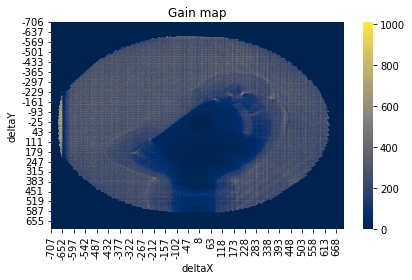

In [14]:
mcp_map.show_map("counts", cmap="cividis")

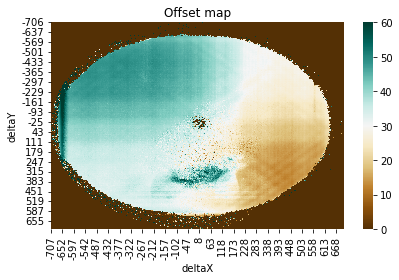

In [9]:
mcp_map.show_map("mean", cmap="BrBG", vmin = 0, vmax = 60)

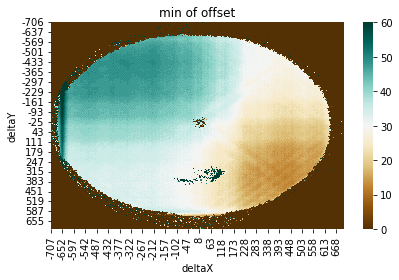

In [12]:
mcp_map.show_map("min", cmap="BrBG", vmin = 0, vmax = 60)
print("WARNING : j'ai fait une erreur de code et j'ai appelé min la médiane !!!")

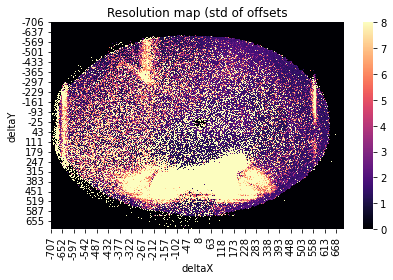

In [13]:
mcp_map.show_map("std", cmap="magma", vmin = 0, vmax = 8)

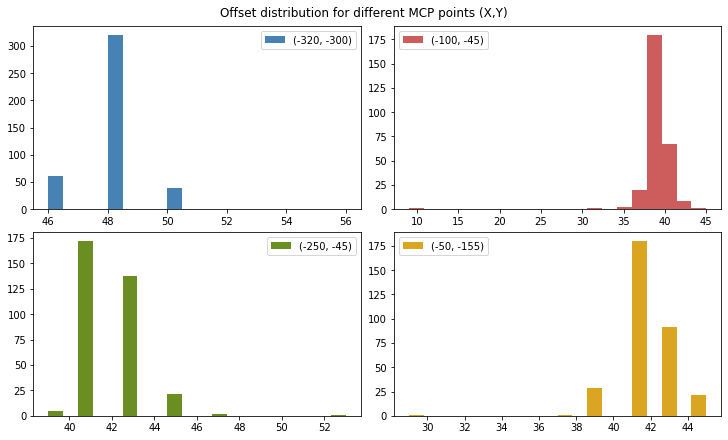

In [11]:
mcp_map.show_offset_distribution(points=[(-320, -300), (-100, -45), (-250, -45), (-50, -155)])

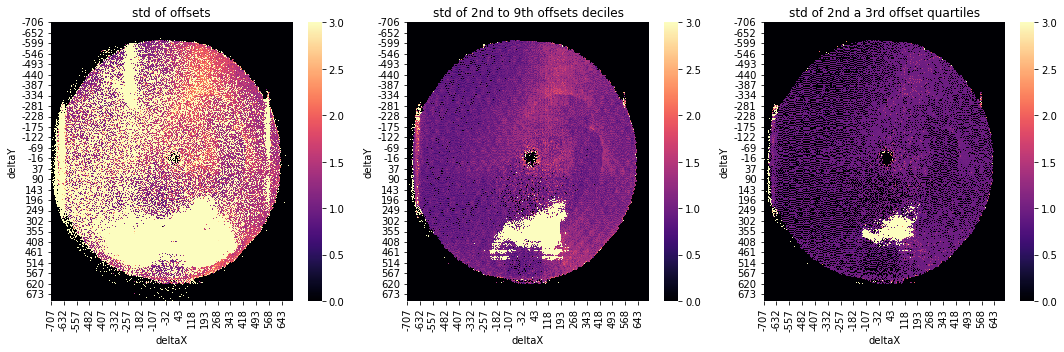

In [14]:
mcp_map.show_three_detectivity_maps(vmin=0, vmax=3, cmap="magma")

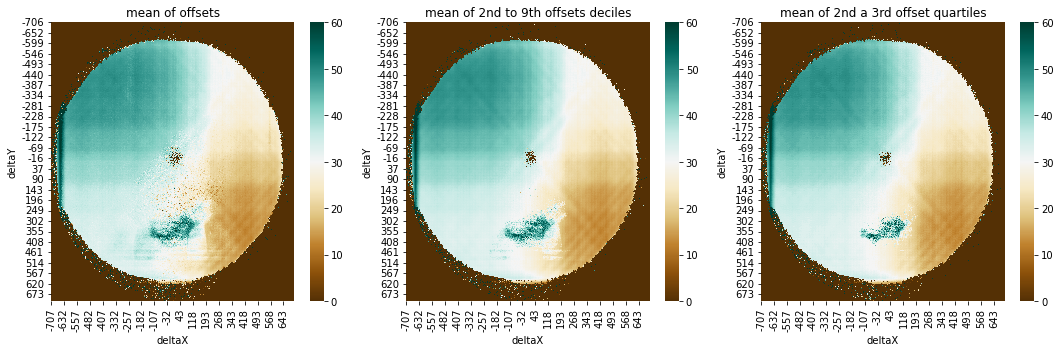

In [7]:
mcp_map.show_three_offset_maps(cmap="BrBG", vmin = 0, vmax = 60)